# **Inteligência Artificial aplicada à Visão Computacional**

**Capítulo 8: Visão Computacional aplicada ao reconhecimento de texto**



<p align="justify">

Todos os direitos reservados à Facti, 2024
<p>

[www.qualifacti.com.br](https://)

---

<p align="justify">
É importante esclarecer que estas atividades não compõem a avaliação e não haverá correção formal por parte dos instrutores; o objetivo é a autoaprendizagem e prática.
<p>

---

# **Estudo de caso**

## Importando as bibliotecas

In [ ]:
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import zipfile
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import imutils
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Carregando as bases de dados

**Conjunto MNIST 0-9**

In [ ]:
from tensorflow.keras.datasets import mnist

In [ ]:
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

In [ ]:
train_data.shape, test_data.shape
train_labels.shape, test_labels.shape

In [ ]:
digitos_data = np.vstack([train_data, test_data])
digitos_labels = np.hstack([train_labels, test_labels])

In [ ]:
np.random.randint(0, digitos_data.shape[0])

In [ ]:
indice = np.random.randint(0, digitos_data.shape[0])
plt.imshow(digitos_data[indice], cmap='gray')
plt.title('Classe: ' + str(digitos_labels[indice]));

In [ ]:
sns.countplot(digitos_labels);

**Conjunto Kaggle A-Z**

In [ ]:
#!wget https://iaexpert.academy/arquivos/alfabeto_A-Z.zip
!wget https://drive.google.com/file/d/1BWkPbX5e76-x4yLxAorfgoSicq5ectx0/view?usp=sharing

--2024-01-24 22:06:58--  https://drive.google.com/file/d/1BWkPbX5e76-x4yLxAorfgoSicq5ectx0/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 142.251.107.101, 142.251.107.139, 142.251.107.113, ...
Connecting to drive.google.com (drive.google.com)|142.251.107.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘view?usp=sharing’

view?usp=sharing        [ <=>                ]  83.80K  --.-KB/s    in 0.003s  

2024-01-24 22:06:58 (23.8 MB/s) - ‘view?usp=sharing’ saved [85812]



In [ ]:
zip_object = zipfile.ZipFile(file='/content/drive/MyDrive/alfabeto_A-Z.zip', mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [ ]:
dataset_az = pd.read_csv('/content/A_Z Handwritten Data/A_Z Handwritten Data.csv').astype('float32')

In [ ]:
alfabeto_data = dataset_az.drop('0', axis = 1)
alfabeto_labels = dataset_az['0']

In [ ]:
alfabeto_labels

In [ ]:
alfabeto_data = np.reshape(alfabeto_data.values, (alfabeto_data.shape[0], 28, 28))

In [ ]:
indice = np.random.randint(0, alfabeto_data.shape[0])
plt.imshow(alfabeto_data[indice], cmap = 'gray')
plt.title('Classe ' + str(alfabeto_labels[indice]));

In [ ]:
sns.countplot(alfabeto_labels);

**Junção das bases de dados**

In [ ]:
digitos_labels, np.unique(digitos_labels)

In [ ]:
alfabeto_labels, np.unique(alfabeto_labels)

In [ ]:
alfabeto_labels += 10

In [ ]:
data = np.vstack([alfabeto_data, digitos_data])
labels = np.hstack([alfabeto_labels, digitos_labels])

In [ ]:
data = np.array(data, dtype='float32')

In [ ]:
data = np.expand_dims(data, axis = -1)

**Pré-processamento dos dados**

In [ ]:
data[0].min(), data[0].max()
data /= 255.0
np.unique(labels)

In [ ]:
le = LabelBinarizer()
labels = le.fit_transform(labels)

In [ ]:
classes_total = labels.sum(axis=0)

In [ ]:
plt.imshow(data[30000].reshape(28,28), cmap='gray')
plt.title(str(labels[30000]));

In [ ]:
classes_peso = {}
for i in range(0, len(classes_total)):
  #print(i)
  classes_peso[i] = classes_total.max() / classes_total[i]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state = 1)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
augmentation = ImageDataGenerator(rotation_range=10, zoom_range=0.05, width_shift_range=0.1,
                                  height_shift_range=0.1, horizontal_flip = False)

**Criação da estrutura da rede neural**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
rede_neural = Sequential()

rede_neural.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)))
rede_neural.add(MaxPool2D(pool_size=(2,2)))

rede_neural.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
rede_neural.add(MaxPool2D(pool_size=(2,2)))

rede_neural.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='valid'))
rede_neural.add(MaxPool2D(pool_size=(2,2)))

rede_neural.add(Flatten())

rede_neural.add(Dense(64, activation='relu'))
rede_neural.add(Dense(128, activation='relu'))

rede_neural.add(Dense(36, activation='softmax'))

rede_neural.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
rede_neural.summary()

In [ ]:
nomes_labels = '0123456789'
nomes_labels += 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
nomes_labels = [l for l in nomes_labels]

**Treinamento da rede neural**

In [ ]:
arquivo_modelo = 'manuscrito.model'
epochs = 20
batch_size = 128

In [ ]:
checkpointer = ModelCheckpoint(arquivo_modelo, monitor='val_loss', verbose=1, save_best_only=True)

In [ ]:
len(X_train) // batch_size

In [ ]:
history = rede_neural.fit(augmentation.flow(X_train, y_train, batch_size=batch_size),
                                            validation_data = (X_test, y_test),
                                            steps_per_epoch = len(X_train) // batch_size,
                                            epochs = epochs,
                                            class_weight = classes_peso,
                                            verbose=1, callbacks=[checkpointer])

**Avaliação da rede neural**

In [ ]:
previsoes = rede_neural.predict(X_test, batch_size=batch_size)

In [ ]:
len(previsoes[0])

In [ ]:
np.argmax(previsoes[0])

In [ ]:
rede_neural.evaluate(X_test, y_test)

In [ ]:
history.history.keys()

In [ ]:
plt.plot(history.history['val_loss']);

In [ ]:
plt.plot(history.history['val_accuracy']);

**Salvando o modelo no Google Drive**

## Conectando com o Drive e acessando os arquivos

Carregando a rede neural



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Realize o dowload da pasta Material_complementar_reconhecimento_texto.zip do Google Sala de Aula e transira-a para o seu Google Drive
# Localize o caminho da pasta no menu Arquivos, no menu lateral esquerdo
path = "/content/drive/MyDrive/Material_complementar_reconhecimento_texto.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")

In [ ]:
rede_neural = load_model('/content/modelos/rede_neural')
rede_neural.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 2, 2, 128)        

## Carregando a imagem de teste

In [ ]:
img = cv2.imread('/content/imagens/manuscrito1.jpg')
cv2_imshow(img)

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

## Pré-processamento da imagem

In [ ]:
desfoque = cv2.GaussianBlur(gray, (3,3), 0)
cv2_imshow(desfoque)

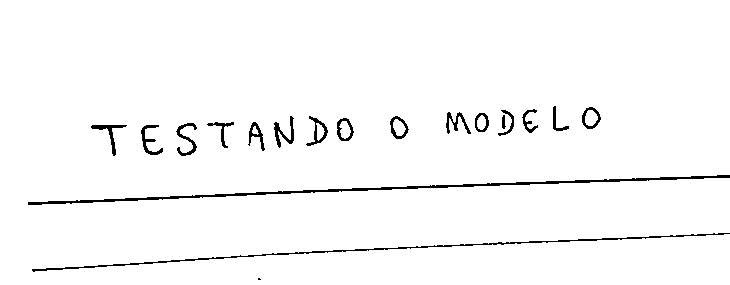

In [ ]:
adapt_media = cv2.adaptiveThreshold(desfoque, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)
cv2_imshow(adapt_media)

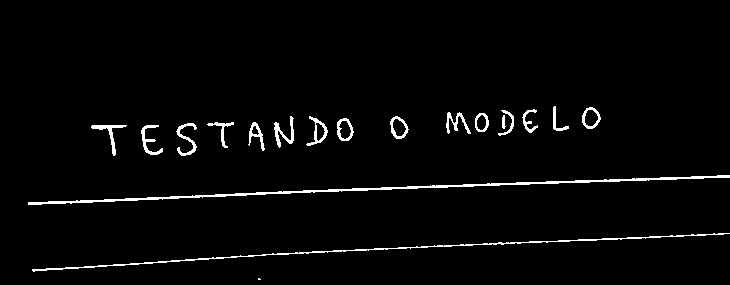

In [ ]:
inv = 255 - adapt_media
cv2_imshow(inv)

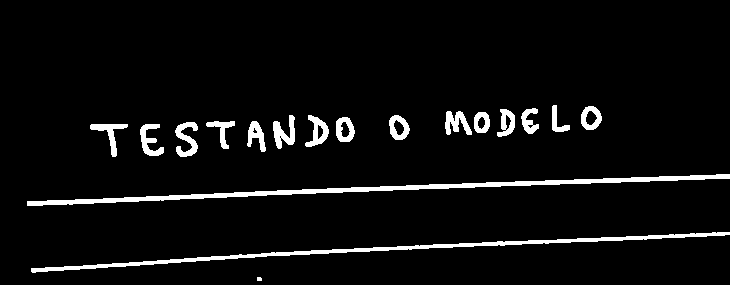

In [ ]:
dilatado = cv2.dilate(inv, np.ones((3,3)))
cv2_imshow(dilatado)

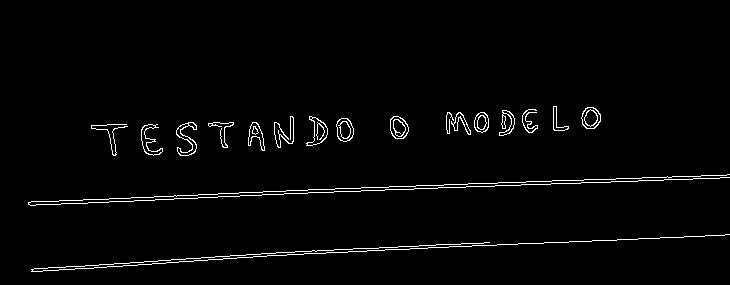

In [ ]:
bordas = cv2.Canny(desfoque, 40, 150)
cv2_imshow(bordas)

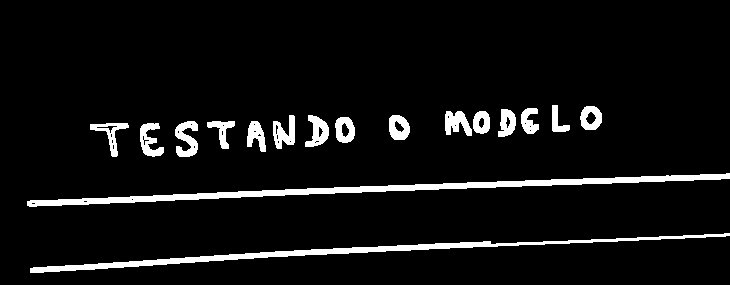

In [ ]:
dilatado = cv2.dilate(bordas, np.ones((3,3)))
cv2_imshow(dilatado)

## Detecção de contornos

In [ ]:
def encontrar_contornos(img):
  conts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  conts = imutils.grab_contours(conts)
  conts = sort_contours(conts, method='left-to-right')[0]
  return conts

In [ ]:
conts = encontrar_contornos(dilatado.copy())

In [ ]:
l_min, l_max = 4, 160
a_min, a_max = 14, 140

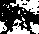

In [ ]:
caracteres = []
img_cp = img.copy()
for c in conts:
  #print(c)
  (x, y, w, h) = cv2.boundingRect(c)
  #print(x, y, w, h)
  if (w >= l_min and w <= l_max) and (h >= a_min and h <= a_max):
    roi = gray[y:y+ h, x:x + w]
    #cv2_imshow(roi)
    thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    cv2_imshow(thresh)
    cv2.rectangle(img_cp, (x, y), (x + w, y + h), (255, 100, 0), 2)
cv2_imshow(img_cp)

## Processando os caracteres detectados

## Extração ROI


In [ ]:
def extra_roi(img):
  roi = img[y:y + h, x:x + w]
  return roi

## Limiarização

In [ ]:
def limiarizacao(img):
  thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
  return thresh

## Redimensionamento

In [ ]:
def redimensiona_img(img, l, a):
  if l > a:
    redimensionada = imutils.resize(img, width=28)
  else:
    redimensionada = imutils.resize(img, height=28)

  (a, l) = redimensionada.shape
  dX = int(max(0, 28 - l) / 2.0)
  dY = int(max(0, 28 - a) / 2.0)

  preenchida = cv2.copyMakeBorder(redimensionada, top=dY, bottom=dY, right=dX, left=dX, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
  preenchida = cv2.resize(preenchida, (28, 28))
  return preenchida

In [ ]:
(x, y, w, h) = cv2.boundingRect(conts[6])
print(x, y, w, h)
img_teste = limiarizacao(gray[y:y+h, x:x+w])
cv2_imshow(img_teste)
(a, l) = img_teste.shape
print(a, l)
img_teste2 = redimensiona_img(img_teste, l, a)
cv2_imshow(img_teste2)
img_teste2.shape

In [ ]:
cv2_imshow(cv2.resize(img_teste, (28,28)))

## Normalização

In [ ]:
def normalizacao(img):
  img = img.astype('float32') / 255.0
  img = np.expand_dims(img, axis=-1)
  return img

In [ ]:
img_teste2.shape, normalizacao(img_teste2).shape

## Processamento das detecções

In [ ]:
def processa_caixa(gray, x, y, w, h):
  roi = extra_roi(gray)
  limiar = limiarizacao(roi)
  (a, l) = limiar.shape
  redimensionada = redimensiona_img(limiar, l, a)
  cv2_imshow(redimensionada)
  normalizada = normalizacao(redimensionada)
  caracteres.append((normalizada, (x, y, w, h)))

In [ ]:
for c in conts:
  #print(c)
  (x, y, w, h) = cv2.boundingRect(c)
  if (w >= l_min and w <= l_max) and (h >= a_min and h <= a_max):
    processa_caixa(gray, x, y, w, h)

In [ ]:
caixas = [caixa[1] for caixa in caracteres]

In [ ]:
caracteres = np.array([c[0] for c in caracteres], dtype='float32')

# Reconhecimento dos caracteres

In [ ]:
numeros = "0123456789"
letras = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
lista_caracteres = numeros + letras
lista_caracteres = [l for l in lista_caracteres]

In [ ]:
caracteres[0].shape

(28, 28, 1)

In [ ]:
caracteres.shape

(30, 28, 28, 1)

In [ ]:
previsoes = rede_neural.predict(caracteres)

1/1 [==============================] - 0s 121ms/step


In [ ]:
previsoes.shape

(30, 36)

In [ ]:
img_cp = img.copy()
for (previsoes, (x, y, w, h)) in zip(previsoes, caixas):
  i = np.argmax(previsoes)
  #print(i)
  probabilidade = previsoes[i]
  #print(probabilidade)
  caractere = lista_caracteres[i]
  #print(caractere)

  cv2.rectangle(img_cp, (x, y), (x + w, y + h), (255,100,0), 2)
  cv2.putText(img_cp, caractere, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0,0,255), 2)
  print(caractere, ' -> ', probabilidade * 100)

  cv2_imshow(img_cp)

G  ->  32.18938708305359


In [ ]:
def extrai_roi(img, margem=2):
  roi = img[y - margem:y + h + margem, x - margem:x + w + margem]
  return roi

In [ ]:
conts = encontrar_contornos(dilatado.copy())
caracteres = []
for c in conts:
  (x, y, w, h) = cv2.boundingRect(c)
  if (w >= l_min and w <= l_max) and (h >= a_min and h <= a_max):
    processa_caixa(gray, x, y, w, h)

In [ ]:
caixas = [b[1] for b in caracteres]
caracteres = np.array([c[0] for c in caracteres], dtype="float32")
previsoes = rede_neural.predict(caracteres)

In [ ]:
img_cp = img.copy()
for (previsoes, (x, y, w, h)) in zip(previsoes, caixas):
  i = np.argmax(previsoes)
  probabilidade = previsoes[i]
  caractere = lista_caracteres[i]

  cv2.rectangle(img_cp, (x, y), (x + w, y + h), (255,100,0), 2)
  cv2.putText(img_cp, caractere, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0,0,255), 2)
  print(caractere, ' -> ', probabilidade * 100)

  cv2_imshow(img_cp)